In [ ]:
%%capture
!pip install tifffile scikit-image opencv-python numpy matplotlib

In [ ]:
import numpy as np
import cv2
import tifffile
import matplotlib.pyplot as plt
from skimage import exposure
from scipy.ndimage import gaussian_filter
import xml.etree.ElementTree as ET
from matplotlib import cm
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D

Loading and cropping image...
Saved original_image.png
Parsing XML metadata...
Generating DEM with 10 iterations...
Normalizing DEM...
Saving outputs...
Saved dem_normalized.png and dem_data.tif
Generating visualization...


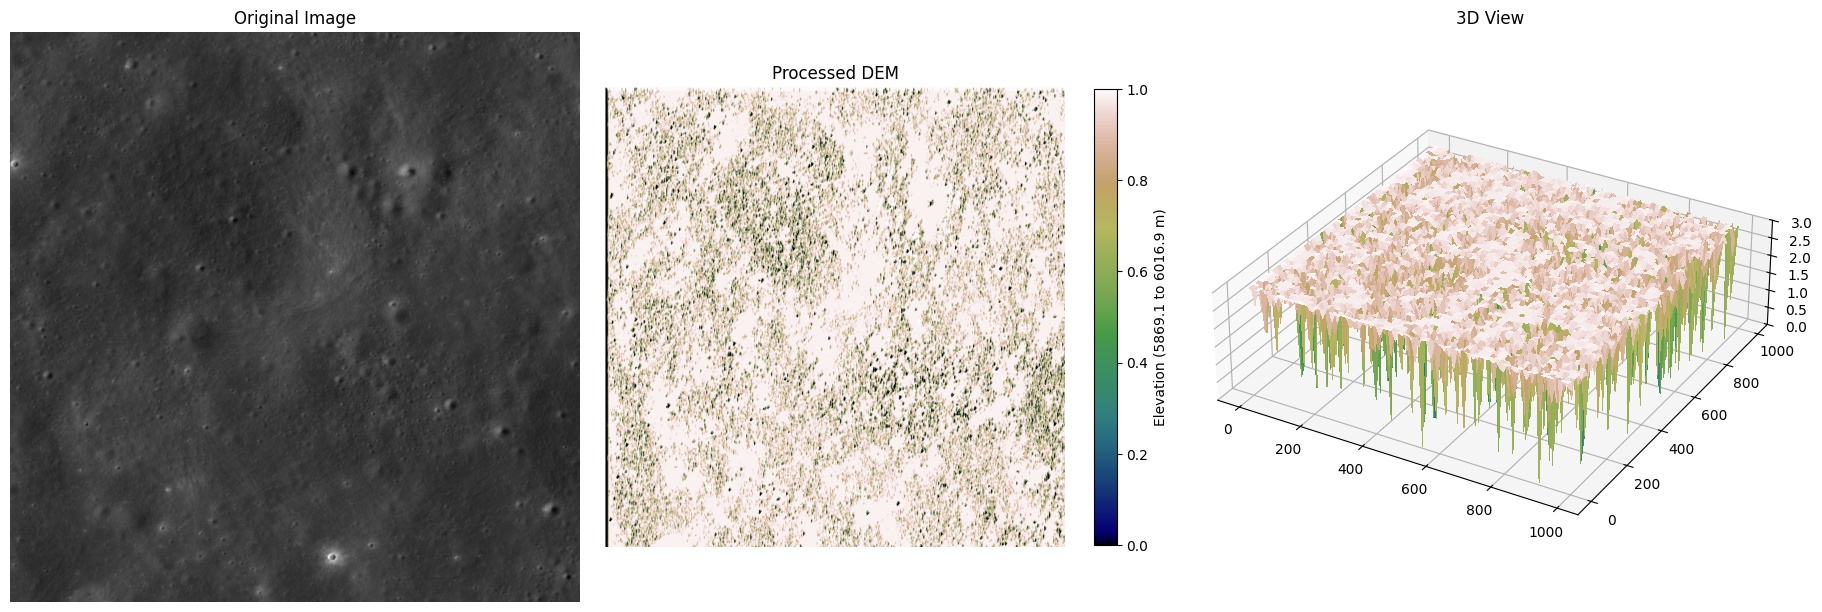

Saved dem_visualization.png


In [11]:
CROP_REGION = (10000, 11000, 3000, 4000)
GAUSSIAN_SIGMA = 50
NUM_ITERATIONS = 10
VERTICAL_EXAGGERATION = 3

def parse_xml_metadata(xml_path):
    namespaces = {'isda': 'https://isda.issdc.gov.in/pds4/isda/v1'}
    tree = ET.parse(xml_path)
    root = tree.getroot()
    sun_azimuth = float(root.find('.//isda:sun_azimuth', namespaces).text)
    sun_elevation = float(root.find('.//isda:sun_elevation', namespaces).text)
    return sun_azimuth, sun_elevation

def calculate_light_vector(azimuth_deg, elevation_deg):
    azimuth_rad = np.radians(azimuth_deg)
    elevation_rad = np.radians(elevation_deg)
    math_azimuth = np.pi/2 - azimuth_rad
    Lx = np.cos(elevation_rad) * np.cos(math_azimuth)
    Ly = np.cos(elevation_rad) * np.sin(math_azimuth)
    Lz = np.sin(elevation_rad)
    return np.array([Lx, Ly, Lz])

def process_photoclinometry(image, light_vector, num_iterations=10):
    image = image.astype(np.float32)
    normalized_img = exposure.rescale_intensity(image, out_range=(0, 1))
    albedo = gaussian_filter(normalized_img, sigma=GAUSSIAN_SIGMA)
    albedo = np.clip(albedo, 1e-6, None)
    reflectance = np.clip(normalized_img / albedo, 0, 1)
    height_map = np.zeros_like(reflectance)
    Lx, Ly, Lz = light_vector

    for _ in range(num_iterations):
        new_height = height_map.copy()
        for i in range(1, height_map.shape[0]):
            for j in range(1, height_map.shape[1]):
                p = height_map[i, j] - height_map[i-1, j]
                q = height_map[i, j] - height_map[i, j-1]
                norm_mag = np.sqrt(1 + p**2 + q**2)
                numerator = Lx*height_map[i-1, j] + Ly*height_map[i, j-1] + Lz - reflectance[i, j]*norm_mag
                new_height[i, j] = numerator / (Lx + Ly)
        height_map = new_height
    return height_map

def normalize_dem(dem):
    dem_shifted = dem - np.min(dem)
    vmin = np.percentile(dem_shifted, 2)
    vmax = np.percentile(dem_shifted, 98)
    dem_clipped = np.clip(dem_shifted, vmin, vmax)
    return (dem_clipped - vmin) / (vmax - vmin), vmin, vmax

def visualize_results(original_img, dem_normalized, vmin, vmax, save_path=None):
    plt.figure(figsize=(18, 6))

    plt.subplot(131)
    plt.imshow(original_img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(132)
    dem_plot = plt.imshow(dem_normalized, cmap='gist_earth', vmin=0, vmax=1)
    cbar = plt.colorbar(dem_plot, shrink=0.8)
    cbar.set_label(f'Elevation ({vmin:.1f} to {vmax:.1f} m)')
    plt.title('Processed DEM')
    plt.axis('off')

    ax = plt.subplot(133, projection='3d')
    y, x = np.mgrid[:dem_normalized.shape[0], :dem_normalized.shape[1]]
    stride = max(1, dem_normalized.shape[0]//100)

    surf = ax.plot_surface(x[::stride,::stride], y[::stride,::stride],
                         dem_normalized[::stride,::stride] * VERTICAL_EXAGGERATION,
                         cmap='gist_earth', rstride=1, cstride=1,
                         linewidth=0, antialiased=False)

    plt.title('3D View')
    ax.set_zlim(0, 1 * VERTICAL_EXAGGERATION)
    ax.set_box_aspect((1, 1, 0.3))

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def main():

    print("Loading and cropping image...")
    img = tifffile.imread('/content/ch2_tmc_ndn_20250217T0120183473_d_oth_d18.tif')
    cropped_img = img[CROP_REGION[0]:CROP_REGION[1], CROP_REGION[2]:CROP_REGION[3]]
    plt.imsave('/content/original_image.png', cropped_img, cmap='gray')
    print("Saved original_image.png")

    print("Parsing XML metadata...")
    sun_az, sun_el = parse_xml_metadata('/content/ch2_tmc_ndn_20250217T0120183473_d_oth_d18.xml')
    light_vec = calculate_light_vector(sun_az, sun_el)

    print(f"Generating DEM with {NUM_ITERATIONS} iterations...")
    raw_dem = process_photoclinometry(cropped_img, light_vec, NUM_ITERATIONS)

    print("Normalizing DEM...")
    dem_normalized, vmin, vmax = normalize_dem(raw_dem)

    print("Saving outputs...")
    plt.imsave('/content/dem_normalized.png', dem_normalized, cmap='gist_earth')
    tifffile.imwrite('/content/dem_data.tif', np.stack([
        raw_dem.astype(np.float32),
        dem_normalized.astype(np.float32)
    ]))
    print("Saved dem_normalized.png and dem_data.tif")

    print("Generating visualization...")
    visualize_results(cropped_img, dem_normalized, vmin, vmax, '/content/dem_visualization.png')
    print("Saved dem_visualization.png")

if __name__ == "__main__":
    main()